In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
#change this to proper csv file
df = pd.read_csv('cleaned_songs_data.csv')

In [3]:

#standard stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

#add artist names to stopwards
artist_names = df['artist_name'].unique()
for name in artist_names:
    words_in_name = name.lower().split()
    stop_words.update(words_in_name)

#adding additional miscellaneous terms and numbers to stopwords
additional_stopwords = ['feat', 'contributors'] + [str(i) for i in range(10)]
stop_words.update(additional_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [5]:
# Remove rows with missing values
df = df.dropna()


genres = ['country', 'hip_hop', 'rock', 'jazz', 'pop']

#remove and tracks not within the specified genres
df = df[df['genre'].isin(genres)]


In [6]:
def filter_lyrics(lyrics):

    words = lyrics.lower().split()
    filtered_words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_words)

#create new filtered_lyrics column
df['filtered_lyrics'] = df['lyrics'].apply(filter_lyrics)

In [7]:
#training and splitting data

X_train, X_test, y_train, y_test = train_test_split(df['lyrics'], df['genre'], test_size=0.2)


text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('clf', svm.SVC()),
])

text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     country       1.00      0.88      0.94        50
     hip_hop       0.94      0.94      0.94        34
        jazz       0.89      0.71      0.79        24
         pop       0.79      0.84      0.81        31
        rock       0.77      0.95      0.85        39

    accuracy                           0.88       178
   macro avg       0.88      0.86      0.87       178
weighted avg       0.89      0.88      0.88       178



In [8]:
# let the user input lyrics and predict the genre

lyrics = "I like big butts and I cannot lie"
predicted_genre = text_clf.predict([lyrics])
print(predicted_genre[0])

rock


In [9]:
# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')



Accuracy: 0.8764


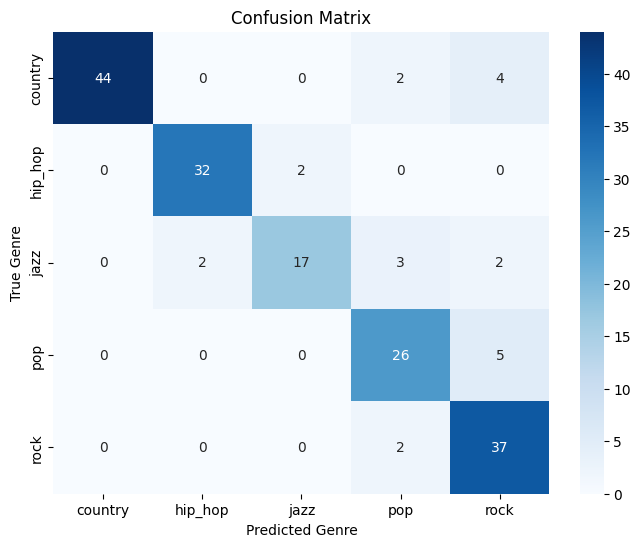

In [10]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=text_clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=text_clf.classes_,
            yticklabels=text_clf.classes_)
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
plt.title('Confusion Matrix')
plt.show()



In [11]:
# Perform cross-validation
scores = cross_val_score(text_clf, df['lyrics'], df['genre'], cv=5)
print(f'Cross-validation scores: {scores}')
print(f'Mean cross-validation score: {scores.mean():.4f}')

Cross-validation scores: [0.92696629 0.93258427 0.94382022 0.90960452 0.92090395]
Mean cross-validation score: 0.9268


In [12]:
from textblob import TextBlob

# Adding sentiment column for genre sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['lyrics'].apply(get_sentiment)

df.head().sort_values(by='sentiment')





,artist_name,track_name,genre,lyrics,filtered_lyrics,sentiment
4,Van Halen,Jump,rock,"Ow! I get up, and nothing gets me down You got...",nothing gets got seen toughest around feel got...,-0.351231
2,David Bowie,Heroes,rock,"I, I will be king And you, you will be queen T...",though nothing drive away beat mean drink time...,-0.312500
1,Led Zeppelin,Immigrant Song,rock,"​ (Two, three, four) Ahh! Ahh! We come from th...",come land ice snow midnight flow hammer gods d...,0.076623
3,Matchbox Twenty,Push,rock,"She said, ""I don't know if I've ever been good...",know ever good enough little bit rusty think h...,0.133681
0,Red Hot Chili Peppers,Can't Stop,rock,"Can't stop, addicted to the shindig Chop Top, ...",addicted shindig chop says gonna win big choos...,0.285294


In [13]:
# Display mean sentiment by genre
print(df.groupby('genre')['sentiment'].mean())


genre
country    0.092908
hip_hop   -0.002366
jazz       0.118467
pop        0.119794
rock       0.054094
Name: sentiment, dtype: float64


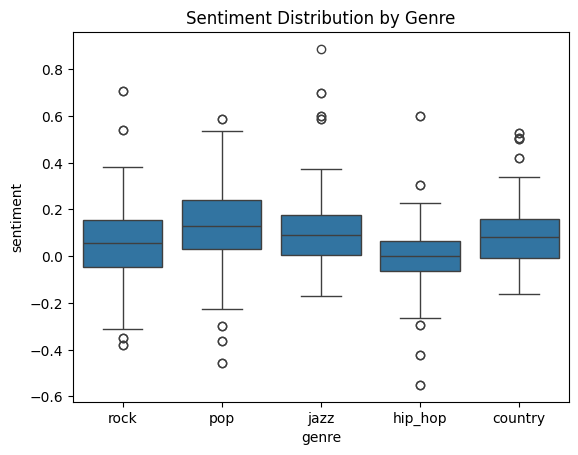

In [14]:
# Plot sentiment distribution by genre
sns.boxplot(x='genre', y='sentiment', data=df)
plt.title("Sentiment Distribution by Genre")
plt.show()

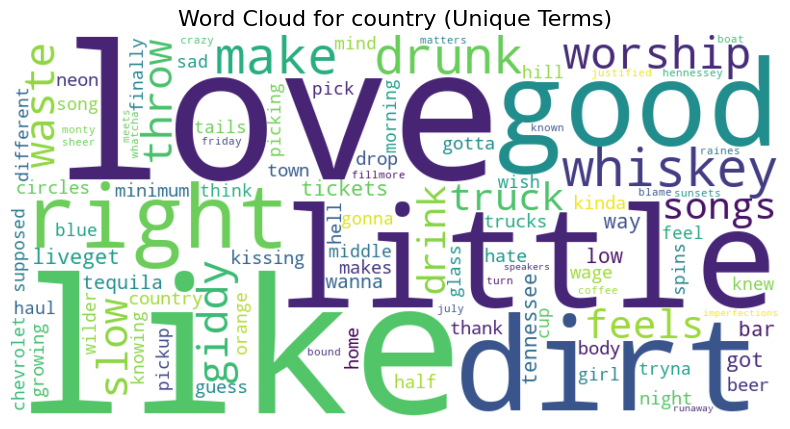

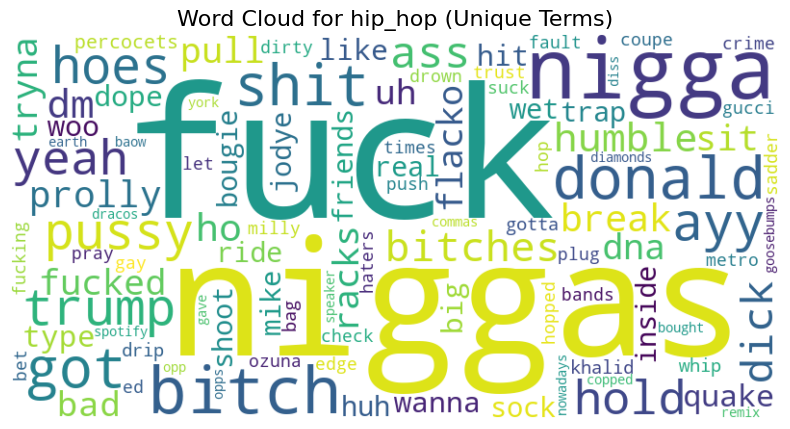

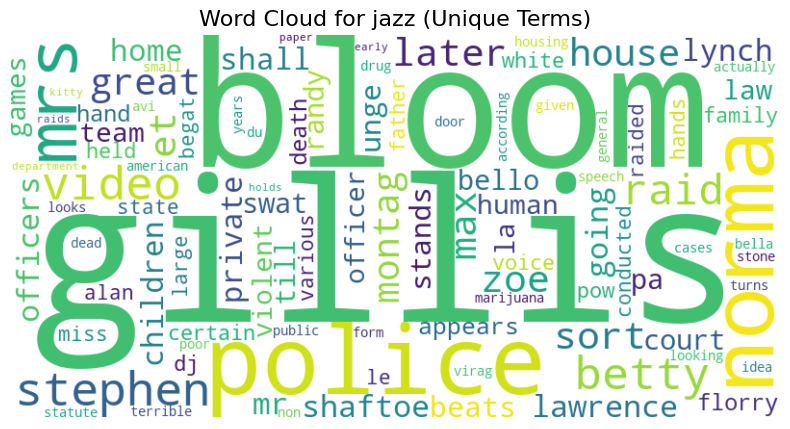

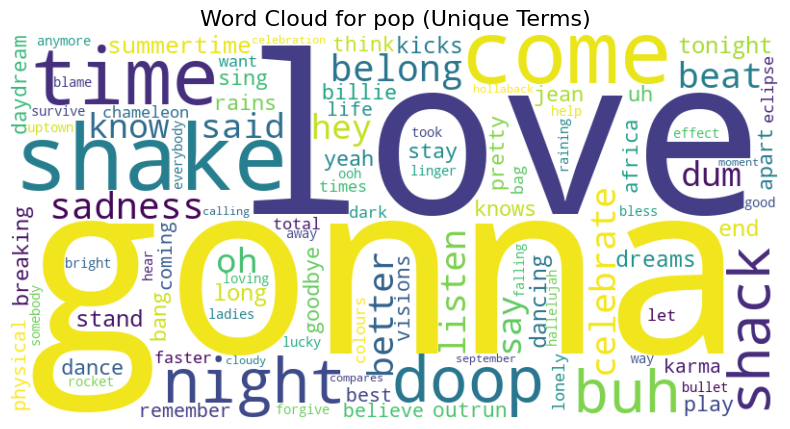

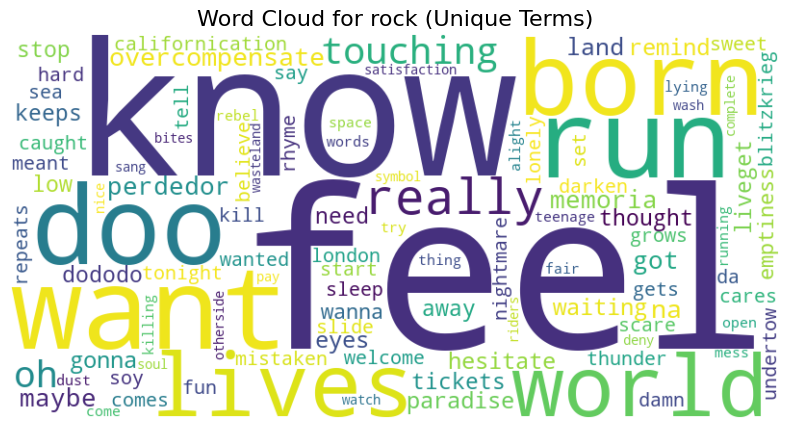

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

grouped = df.groupby('genre')['filtered_lyrics'].apply(' '.join)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(grouped)
feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.T.toarray(), index=feature_names, columns=grouped.index)

#extract unique terms for a specific genre
def get_unique_terms(target_genre, tfidf_df, top_n=100):
    target_scores = tfidf_df[target_genre]
    avg_scores = tfidf_df.drop(columns=target_genre).mean(axis=1)
    uniqueness = target_scores - avg_scores
    unique_terms = uniqueness.sort_values(ascending=False).head(top_n)
    return unique_terms

#generate and save word clouds for all genres
for genre in grouped.index:
    unique_terms = get_unique_terms(genre, tfidf_df)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(unique_terms.to_dict())
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {genre} (Unique Terms)", fontsize=16)
    plt.show()

